## Results Mortality


In [46]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

import xarray

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard
from src.impact_calculation.impact_heat import *
from src.util.plots import *


from scipy.sparse import coo_matrix, vstack

fig_dir = '../../data_analysis/figures/'

In [47]:
directory_exposures = '../../input_data/exposures/'
exposures = {}
for code, category in {'O': 'Over 75', 'U': 'Under 75'}.items():    
    exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', code,'2.h5'])
    exposures[category] = Exposures()
    exposures[category].read_hdf5(exposures_file)
    exposures[category].gdf['value'] = exposures[category].gdf['value']*exposures[category].gdf['total_population_canton']

    #exposures[category] = Exposures(exposures[category])
    exposures[category].check()


/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:219: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf.crs = self.meta['crs']


## Damage cost for each scenario, year and age category

In [48]:
pickle_in = \
open('../../output/mortality_results/impact_CH_values_1000mc.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

In [49]:
data = {}
for scenario in impacts_mortality.median_impact_matrices:
    data[scenario] = {}
    for cat in impacts_mortality.median_impact_matrices[scenario][2020]:
        data[scenario][cat] = vstack([impacts_mortality.median_impact_matrices[scenario][y][cat] 
                for y in impacts_mortality.median_impact_matrices[scenario]]).toarray()
    

In [7]:
impacts_mortality.median_impact_matrices[scenario][2020][cat]

<1x344588 sparse matrix of type '<class 'numpy.float64'>'
	with 335938 stored elements in Compressed Sparse Row format>

In [8]:
data['RCP26']['Over 75'].shape

(5, 344588)

In [9]:
exposures['Over 75']

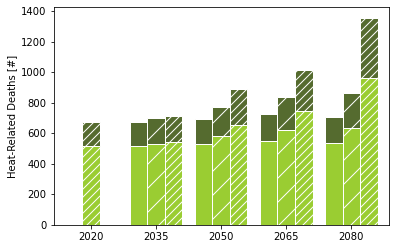

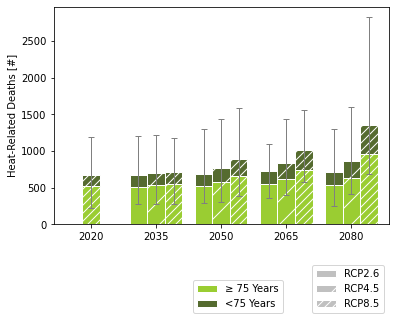

In [50]:
plot_impacts_heat(impacts_mortality.agg_impacts_mc, unit='Heat-Related Deaths [#]', impact_type='mortality', color=['yellowgreen', 'darkolivegreen'], labels_cat=['≥ 75 Years','<75 Years'], save=True)



In [59]:
impacts_mortality.agg_impacts_mc['RCP85'][2080]['Over 75'].median()+impacts_mortality.agg_impacts_mc['RCP85'][2080]['Under 75'].median()

1355.7602431740715

In [67]:
np.median(impacts_mortality.agg_impacts_mc['RCP85'][2080]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc['RCP85'][2080]['Under 75'])-np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Over 75'])-np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Under 75'])


647.1080853749678

In [71]:
(np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Under 75']))


708.6521577991037

In [13]:
def median_death(scenario, year, category='all'):
    if category=='all':
        median_death = (np.median(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.median(impacts_mortality.agg_impacts_mc[scenario][year][category])
    return median_death

def percentile_death(scenario, year, percentile, category='all'):
    if category=='all':
        median_death = (np.percentile(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'], percentile)+np.percentile(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75'], percentile))
    else:    
        median_death = np.percentile(impacts_mortality.agg_impacts_mc[scenario][year][category],percentile)
    return median_death

def max_death(scenario, year, category='all'):
    if category=='all':
        median_death = (np.max(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'])+np.max(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.max(impacts_mortality.agg_impacts_mc[scenario][year][category])
    return median_death

In [60]:
print(percentile_death('RCP85', 2050, 40, category='all'))
print(percentile_death('RCP85', 2050, 60, category='all'))
print(median_death('RCP85', 2050))

print(median_death('RCP85', 2050) - percentile_death('RCP85', 2050, 90, category='all'))
print(median_death('RCP85', 2050) - percentile_death('RCP85', 2050, 95, category='all'))


783.2801594858009
974.449085616953
887.8974933005869
-475.4024239070733
-693.4413956347383


In [65]:
percentile_death('RCP85', 2050, 60, category='all')

974.449085616953

## Spatial Impact

/Users/zeliestalhanske/python_projects/climada_python/climada/util/plot.py:326: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
/Users/zeliestalhanske/miniconda/envs/climada_env/lib/python3.8/site-packages/cartopy/mpl/feature_artist.py:222: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  c = matplotlib.collections.PathCollection(
/Users/zeliestalhanske/miniconda/envs/climada_env/lib/python3.8/site-packages/cartopy/mpl/feature_artist.py:222: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  c = matplotlib.collections.PathCollection(


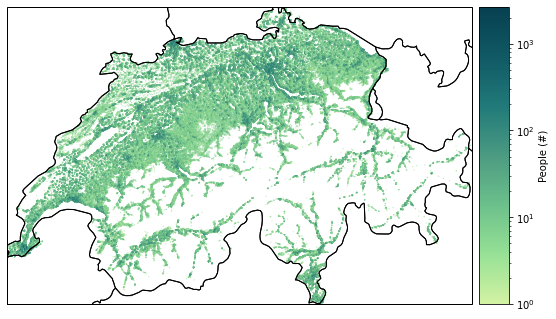

In [16]:
from climada.util.plot import make_map
import cartopy.crs as ccrs
import matplotlib
cm = palettable.cartocolors.sequential.Emrld_7.mpl_colormap

exposures['Under 75'].check()
exposures['Under 75'].to_crs(epsg=3785, inplace=True)

exposures['Under 75'].plot_hexbin(pop_name=False, cmap=cm, buffer=0.1, cbar_label='People (#)', norm=matplotlib.colors.LogNorm())
plt.savefig('../figures/map_exposures_ch_u75.pdf',bbox_inches='tight')   


/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:188: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf = GeoDataFrame(*args, **kwargs)
/Users/zeliestalhanske/python_projects/climada_python/climada/util/plot.py:326: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
/Users/zeliestalhanske/miniconda/envs/climada_env/lib/python3.8/site-packages/cartopy/mpl/feature_artist.py:222: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  c = matplotlib.collections.PathCollection(
/Users/zeliestalhanske/miniconda/envs/climada_env/lib/python3.8/site-packages/cartopy/mpl/feature_artist.py:222: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence 

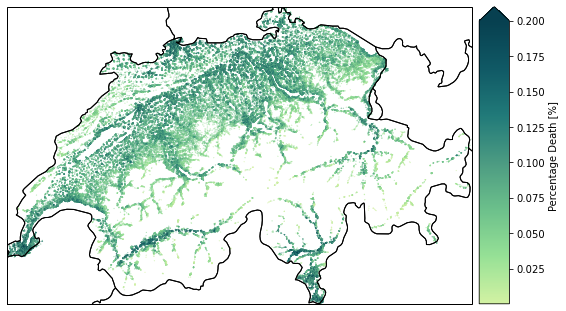

In [17]:
category = 'Over 75'
categories_code = {'Over 75':'O', 'Under 75':'U'}
cm = palettable.cartocolors.sequential.Emrld_7.mpl_colormap

impact = impacts_mortality.matrix_as_impact(impacts_mortality.median_impact_matrices['RCP85'][2050][category], exposures[category], percentage=True, unit='%')
impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, vmax=0.2, extend='max', proj=3785, cbar_label='Percentage Death [%]')

plt.savefig(''.join([fig_dir,'spatial_impact_2050_o75.pdf']),bbox_inches='tight')

## Relative change map

../../src/impact_calculation/impact_heat.py:157: RuntimeWarning: divide by zero encountered in true_divide
  matrix_rel = (np.nan_to_num((matrix.toarray() - matrix_ref.toarray()) / matrix_ref.toarray())) * 100
../../src/impact_calculation/impact_heat.py:157: RuntimeWarning: invalid value encountered in true_divide
  matrix_rel = (np.nan_to_num((matrix.toarray() - matrix_ref.toarray()) / matrix_ref.toarray())) * 100
../../src/impact_calculation/impact_heat.py:157: RuntimeWarning: overflow encountered in multiply
  matrix_rel = (np.nan_to_num((matrix.toarray() - matrix_ref.toarray()) / matrix_ref.toarray())) * 100
/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:188: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf = GeoDataFrame(*args, **kwargs)
/Users/zeliestalhanske/python_projects/climada_python/climada/util/plot.py:326: UserWarning: Tight layout not app

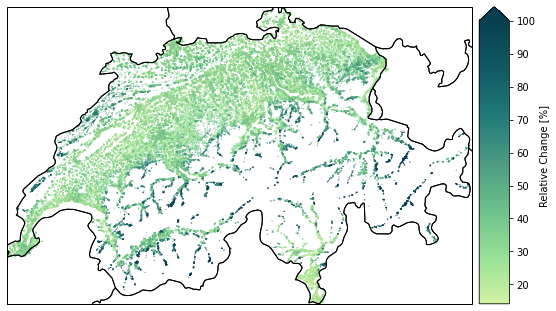

In [18]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP85'][2050][category], impacts_mortality.median_impact_matrices['RCP85'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures[category], unit='%')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1, vmax=100, extend='max', proj=3785, cbar_label='Relative Change [%]')

plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75.pdf']),bbox_inches='tight')

../../src/impact_calculation/impact_heat.py:157: RuntimeWarning: divide by zero encountered in true_divide
  matrix_rel = (np.nan_to_num((matrix.toarray() - matrix_ref.toarray()) / matrix_ref.toarray())) * 100
../../src/impact_calculation/impact_heat.py:157: RuntimeWarning: invalid value encountered in true_divide
  matrix_rel = (np.nan_to_num((matrix.toarray() - matrix_ref.toarray()) / matrix_ref.toarray())) * 100
../../src/impact_calculation/impact_heat.py:157: RuntimeWarning: overflow encountered in multiply
  matrix_rel = (np.nan_to_num((matrix.toarray() - matrix_ref.toarray()) / matrix_ref.toarray())) * 100
/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:188: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf = GeoDataFrame(*args, **kwargs)
/Users/zeliestalhanske/python_projects/climada_python/climada/util/plot.py:326: UserWarning: Tight layout not app

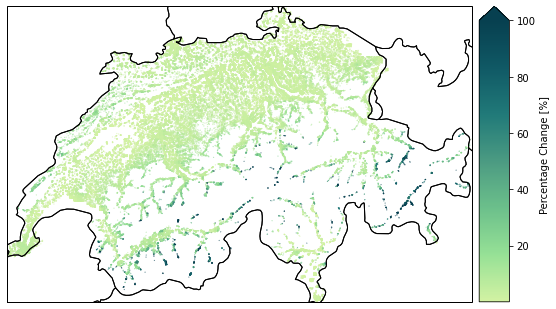

In [19]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP26'][2050][category], impacts_mortality.median_impact_matrices['RCP85'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures[category], unit='%')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1, vmax=100, extend='max', proj=3785, cbar_label='Percentage Change [%]')

plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75_rcp26.pdf']),bbox_inches='tight')

## Make Table with Cantonal Values

In [28]:
categories_short = {'Over 75': '≥75', 'Under 75': '<75'}
cantonal_impacts_df = impacts_mortality.median_impact_matrices['RCP26'][2020]=impacts_mortality.median_impact_matrices['RCP26'][2080]
cantonal_impacts_df = impacts_mortality.median_impact_matrices['RCP45'][2020]=impacts_mortality.median_impact_matrices['RCP45'][2080]

cantonal_impacts_df = impacts_mortality.cantonal_impacts_df(exposures, scenarios=['RCP26', 'RCP85'], years=[2020,2050,2080], categories_short=categories_short)


/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:188: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf = GeoDataFrame(*args, **kwargs)


In [29]:
cantonal_impacts_df_rcp45 = impacts_mortality.cantonal_impacts_df(exposures, scenarios=['RCP45'], years=[2020,2050,2080], categories_short=categories_short)


In [30]:
cantonal_impacts_df_rcp45

RCP4.5                                      \
                              2020                    2050               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   44.326361   20.713594   47.979359   18.620369   
Appenzell Ausserrhoden    2.320527    0.822778    2.423853    0.701739   
Appenzell Innerrhoden     0.704984    0.246478    0.737377    0.209539   
Basel-Landschaft         23.188232    8.128244   25.390504    7.362230   
Basel-Stadt              13.188667    4.740279   14.552657    4.353832   
Bern                     70.027109   26.463953   74.884337   22.923339   
Fribourg                 16.677427    8.706994   17.935712    7.545115   
Genève                   30.978471   15.792411   33.362150   13.858248   
Glarus                    2.199414    0.808227    2.294472    0.672091   
Graubünden               11.704997    4.433725   11.772564    3.580356   
Jura                      5.658646    2.173312    6.075234    1.910575   
Luzern                   22.899832   10.167546   24.748918    8.909843   
Neuchâtel                 9.271280    3.407983    9.944373    2.964521   
Nidwalden                 2.623632    1.012291    2.807157    0.870012   
Obwalden                  2.037851    0.879672    2.142519    0.748232   
Schaffhausen              6.124365    2.344329    6.684884    2.105645   
Schwyz                    7.494042    3.127133    8.013765    2.681684   
Solothurn                20.671767    8.593081   22.404739    7.705516   
St. Gallen               27.790449   11.569592   29.473488    9.937062   
Thurgau                  16.105876    7.369442   17.387872    6.463903   
Ticino                   35.824842   11.525724   39.070393    9.954376   
Uri                       1.952376    0.725046    2.014860    0.597045   
Valais                   24.910315   10.886819   25.783243    9.058321   
Vaud                     43.902378   19.343944   47.547407   16.759446   
Zug                       5.707372    2.564968    6.162644    2.258645   
Zürich                   83.293526   35.833501   89.749306   31.805735   
Total                   531.584740  222.381065  571.343788  194.557416   

                                                
                              2080              
                               ≥75         <75  
canton                                          
Aargau                   44.326361   20.713594  
Appenzell Ausserrhoden    2.320527    0.822778  
Appenzell Innerrhoden     0.704984    0.246478  
Basel-Landschaft         23.188232    8.128244  
Basel-Stadt              13.188667    4.740279  
Bern                     70.027109   26.463953  
Fribourg                 16.677427    8.706994  
Genève                   30.978471   15.792411  
Glarus                    2.199414    0.808227  
Graubünden               11.704997    4.433725  
Jura                      5.658646    2.173312  
Luzern                   22.899832   10.167546  
Neuchâtel                 9.271280    3.407983  
Nidwalden                 2.623632    1.012291  
Obwalden                  2.037851    0.879672  
Schaffhausen              6.124365    2.344329  
Schwyz                    7.494042    3.127133  
Solothurn                20.671767    8.593081  
St. Gallen               27.790449   11.569592  
Thurgau                  16.105876    7.369442  
Ticino                   35.824842   11.525724  
Uri                       1.952376    0.725046  
Valais                   24.910315   10.886819  
Vaud                     43.902378   19.343944  
Zug                       5.707372    2.564968  
Zürich                   83.293526   35.833501  
Total                   531.584740  222.381065

In [31]:
cantonal_impacts_df

RCP2.6                                      \
                              2020                    2050               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   37.605735   16.438713   43.751575   15.845084   
Appenzell Ausserrhoden    1.843885    0.610955    2.094339    0.551417   
Appenzell Innerrhoden     0.556558    0.182206    0.635794    0.164185   
Basel-Landschaft         19.963431    6.601168   23.173260    6.382621   
Basel-Stadt              11.345077    3.864053   13.250783    3.800027   
Bern                     58.345848   20.216176   67.903794   19.522291   
Fribourg                 14.016094    6.703891   16.186314    6.364952   
Genève                   25.403812   11.664955   30.345777   11.694499   
Glarus                    1.736650    0.568208    2.020520    0.549578   
Graubünden                8.853932    3.006374   10.410193    2.928961   
Jura                      4.765142    1.706282    5.562813    1.646589   
Luzern                   19.145485    7.746027   22.450783    7.395560   
Neuchâtel                 7.785754    2.690915    8.923361    2.541507   
Nidwalden                 2.165334    0.750875    2.540300    0.721977   
Obwalden                  1.629812    0.636317    1.907787    0.614987   
Schaffhausen              5.241726    1.882055    6.084242    1.794868   
Schwyz                    6.166467    2.340147    7.190287    2.229879   
Solothurn                17.710381    6.847001   20.513492    6.636409   
St. Gallen               22.904345    8.714916   26.545580    8.255461   
Thurgau                  13.584277    5.751258   15.773977    5.489156   
Ticino                   30.309649    8.933799   36.557654    8.784665   
Uri                       1.554341    0.511974    1.812850    0.498945   
Valais                   19.393827    7.657594   23.496447    7.871642   
Vaud                     37.080987   14.941470   43.175866   14.296832   
Zug                       4.766315    1.963113    5.569198    1.869367   
Zürich                   70.368154   27.809813   82.182165   26.858985   
Total                   444.243018  170.740256  520.059151  165.310443   

                                                    RCP8.5              \
                              2080                    2020               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   37.605735   16.438713   43.061676   14.421867   
Appenzell Ausserrhoden    1.843885    0.610955    2.002137    0.544141   
Appenzell Innerrhoden     0.556558    0.182206    0.604245    0.159919   
Basel-Landschaft         19.963431    6.601168   22.738039    5.784799   
Basel-Stadt              11.345077    3.864053   13.166223    3.438239   
Bern                     58.345848   20.216176   66.269154   17.848046   
Fribourg                 14.016094    6.703891   15.885887    5.915449   
Genève                   25.403812   11.664955   29.219093   10.538641   
Glarus                    1.736650    0.568208    1.947576    0.507676   
Graubünden                8.853932    3.006374    9.569222    2.580097   
Jura                      4.765142    1.706282    5.353076    1.479258   
Luzern                   19.145485    7.746027   21.854012    6.877935   
Neuchâtel                 7.785754    2.690915    8.691919    2.333024   
Nidwalden                 2.165334    0.750875    2.442197    0.662185   
Obwalden                  1.629812    0.636317    1.808940    0.558180   
Schaffhausen              5.241726    1.882055    6.011022    1.653906   
Schwyz                    6.166467    2.340147    6.946246    2.075024   
Solothurn                17.710381    6.847001   20.243026    6.006010   
St. Gallen               22.904345    8.714916   26.023887    7.821803   
Thurgau                  13.584

In [32]:
cantonal_impacts_df_total = cantonal_impacts_df.groupby(level=[0,1], axis=1).sum().astype(int)

In [33]:
cantonal_impacts_df_total

RCP2.6           RCP8.5           
                         2020 2050 2080   2020 2050  2080
canton                                                   
Aargau                     54   59   54     57   75   116
Appenzell Ausserrhoden      2    2    2      2    3     5
Appenzell Innerrhoden       0    0    0      0    1     1
Basel-Landschaft           26   29   26     28   36    56
Basel-Stadt                15   17   15     16   21    31
Bern                       78   87   78     84  111   170
Fribourg                   20   22   20     21   29    44
Genève                     37   42   37     39   52    84
Glarus                      2    2    2      2    3     5
Graubünden                 11   13   11     12   18    30
Jura                        6    7    6      6    9    14
Luzern                     26   29   26     28   38    59
Neuchâtel                  10   11   10     11   14    22
Nidwalden                   2    3    2      3    4     6
Obwalden                    2    2    2      2    3     5
Schaffhausen                7    7    7      7    9    15
Schwyz                      8    9    8      9   12    19
Solothurn                  24   27   24     26   34    52
St. Gallen                 31   34   31     33   45    69
Thurgau                    19   21   19     20   27    41
Ticino                     39   45   39     44   54    79
Uri                         2    2    2      2    3     4
Valais                     27   31   27     28   40    64
Vaud                       52   57   52     56   73   109
Zug                         6    7    6      7    9    14
Zürich                     98  109   98    105  137   213
Total                     614  685  614    660  870  1341

In [34]:
cantonal_impacts_df_total.insert(0, 'Baseline (2020)', cantonal_impacts_df_total['RCP8.5'][2020])

In [35]:
cantonal_impacts_df['RCP8.5'][2020]['≥75']/(cantonal_impacts_df['RCP8.5'][2020]['≥75']+cantonal_impacts_df['RCP8.5'][2020]['<75'])
                                                                                                                           

canton
Aargau                    0.749113
Appenzell Ausserrhoden    0.786299
Appenzell Innerrhoden     0.790727
Basel-Landschaft          0.797187
Basel-Stadt               0.792933
Bern                      0.787819
Fribourg                  0.728666
Genève                    0.734929
Glarus                    0.793229
Graubünden                0.787634
Jura                      0.783492
Luzern                    0.760617
Neuchâtel                 0.788387
Nidwalden                 0.786693
Obwalden                  0.764194
Schaffhausen              0.784224
Schwyz                    0.769985
Solothurn                 0.771191
St. Gallen                0.768898
Thurgau                   0.751615
Ticino                    0.814453
Uri                       0.793443
Valais                    0.765419
Vaud                      0.760686
Zug                       0.757321
Zürich                    0.765732
Total                     0.770155
dtype: float64

In [36]:
cantonal_impacts_df

RCP2.6                                      \
                              2020                    2050               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   37.605735   16.438713   43.751575   15.845084   
Appenzell Ausserrhoden    1.843885    0.610955    2.094339    0.551417   
Appenzell Innerrhoden     0.556558    0.182206    0.635794    0.164185   
Basel-Landschaft         19.963431    6.601168   23.173260    6.382621   
Basel-Stadt              11.345077    3.864053   13.250783    3.800027   
Bern                     58.345848   20.216176   67.903794   19.522291   
Fribourg                 14.016094    6.703891   16.186314    6.364952   
Genève                   25.403812   11.664955   30.345777   11.694499   
Glarus                    1.736650    0.568208    2.020520    0.549578   
Graubünden                8.853932    3.006374   10.410193    2.928961   
Jura                      4.765142    1.706282    5.562813    1.646589   
Luzern                   19.145485    7.746027   22.450783    7.395560   
Neuchâtel                 7.785754    2.690915    8.923361    2.541507   
Nidwalden                 2.165334    0.750875    2.540300    0.721977   
Obwalden                  1.629812    0.636317    1.907787    0.614987   
Schaffhausen              5.241726    1.882055    6.084242    1.794868   
Schwyz                    6.166467    2.340147    7.190287    2.229879   
Solothurn                17.710381    6.847001   20.513492    6.636409   
St. Gallen               22.904345    8.714916   26.545580    8.255461   
Thurgau                  13.584277    5.751258   15.773977    5.489156   
Ticino                   30.309649    8.933799   36.557654    8.784665   
Uri                       1.554341    0.511974    1.812850    0.498945   
Valais                   19.393827    7.657594   23.496447    7.871642   
Vaud                     37.080987   14.941470   43.175866   14.296832   
Zug                       4.766315    1.963113    5.569198    1.869367   
Zürich                   70.368154   27.809813   82.182165   26.858985   
Total                   444.243018  170.740256  520.059151  165.310443   

                                                    RCP8.5              \
                              2080                    2020               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   37.605735   16.438713   43.061676   14.421867   
Appenzell Ausserrhoden    1.843885    0.610955    2.002137    0.544141   
Appenzell Innerrhoden     0.556558    0.182206    0.604245    0.159919   
Basel-Landschaft         19.963431    6.601168   22.738039    5.784799   
Basel-Stadt              11.345077    3.864053   13.166223    3.438239   
Bern                     58.345848   20.216176   66.269154   17.848046   
Fribourg                 14.016094    6.703891   15.885887    5.915449   
Genève                   25.403812   11.664955   29.219093   10.538641   
Glarus                    1.736650    0.568208    1.947576    0.507676   
Graubünden                8.853932    3.006374    9.569222    2.580097   
Jura                      4.765142    1.706282    5.353076    1.479258   
Luzern                   19.145485    7.746027   21.854012    6.877935   
Neuchâtel                 7.785754    2.690915    8.691919    2.333024   
Nidwalden                 2.165334    0.750875    2.442197    0.662185   
Obwalden                  1.629812    0.636317    1.808940    0.558180   
Schaffhausen              5.241726    1.882055    6.011022    1.653906   
Schwyz                    6.166467    2.340147    6.946246    2.075024   
Solothurn                17.710381    6.847001   20.243026    6.006010   
St. Gallen               22.904345    8.714916   26.023887    7.821803   
Thurgau                  13.584

In [37]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df_total.to_latex(multicolumn=True))


\begin{tabular}{lrrrrrrr}
\toprule
{} & Baseline (2020) & \multicolumn{3}{l}{RCP2.6} & \multicolumn{3}{l}{RCP8.5} \\
{} &   2020 & 2050 & 2080 &   2020 & 2050 &  2080 \\
canton                 &                 &        &      &      &        &      &       \\
\midrule
Aargau                 &              57 &     54 &   59 &   54 &     57 &   75 &   116 \\
Appenzell Ausserrhoden &               2 &      2 &    2 &    2 &      2 &    3 &     5 \\
Appenzell Innerrhoden  &               0 &      0 &    0 &    0 &      0 &    1 &     1 \\
Basel-Landschaft       &              28 &     26 &   29 &   26 &     28 &   36 &    56 \\
Basel-Stadt            &              16 &     15 &   17 &   15 &     16 &   21 &    31 \\
Bern                   &              84 &     78 &   87 &   78 &     84 &  111 &   170 \\
Fribourg               &              21 &     20 &   22 &   20 &     21 &   29 &    44 \\
Genève                 &              39 &     37 &   42 &   37 &     39 &   52 &    84 \\
Gl

In [38]:
cantonal_impacts_df_total = cantonal_impacts_df_total.drop(columns=2020,level=1)

In [39]:
(cantonal_impacts_df_total['RCP8.5'][2080]-cantonal_impacts_df_total['RCP2.6'][2080])

canton
Aargau                     62
Appenzell Ausserrhoden      3
Appenzell Innerrhoden       1
Basel-Landschaft           30
Basel-Stadt                16
Bern                       92
Fribourg                   24
Genève                     47
Glarus                      3
Graubünden                 19
Jura                        8
Luzern                     33
Neuchâtel                  12
Nidwalden                   4
Obwalden                    3
Schaffhausen                8
Schwyz                     11
Solothurn                  28
St. Gallen                 38
Thurgau                    22
Ticino                     40
Uri                         2
Valais                     37
Vaud                       57
Zug                         8
Zürich                    115
Total                     727
Name: 2080, dtype: int64

In [40]:
cantonal_impacts_df_total['RCP2.6'][2080]

canton
Aargau                     54
Appenzell Ausserrhoden      2
Appenzell Innerrhoden       0
Basel-Landschaft           26
Basel-Stadt                15
Bern                       78
Fribourg                   20
Genève                     37
Glarus                      2
Graubünden                 11
Jura                        6
Luzern                     26
Neuchâtel                  10
Nidwalden                   2
Obwalden                    2
Schaffhausen                7
Schwyz                      8
Solothurn                  24
St. Gallen                 31
Thurgau                    19
Ticino                     39
Uri                         2
Valais                     27
Vaud                       52
Zug                         6
Zürich                     98
Total                     614
Name: 2080, dtype: int64

In [41]:
(cantonal_impacts_df_total['RCP8.5'][2080]-cantonal_impacts_df_total['RCP2.6'][2080])/(cantonal_impacts_df_total['RCP2.6'][2080])




canton
Aargau                    1.148148
Appenzell Ausserrhoden    1.500000
Appenzell Innerrhoden          inf
Basel-Landschaft          1.153846
Basel-Stadt               1.066667
Bern                      1.179487
Fribourg                  1.200000
Genève                    1.270270
Glarus                    1.500000
Graubünden                1.727273
Jura                      1.333333
Luzern                    1.269231
Neuchâtel                 1.200000
Nidwalden                 2.000000
Obwalden                  1.500000
Schaffhausen              1.142857
Schwyz                    1.375000
Solothurn                 1.166667
St. Gallen                1.225806
Thurgau                   1.157895
Ticino                    1.025641
Uri                       1.000000
Valais                    1.370370
Vaud                      1.096154
Zug                       1.333333
Zürich                    1.173469
Total                     1.184039
Name: 2080, dtype: float64

In [42]:
cantonal_impacts_df_total

Baseline (2020) RCP2.6      RCP8.5      
                                         2050 2080   2050  2080
canton                                                         
Aargau                              57     59   54     75   116
Appenzell Ausserrhoden               2      2    2      3     5
Appenzell Innerrhoden                0      0    0      1     1
Basel-Landschaft                    28     29   26     36    56
Basel-Stadt                         16     17   15     21    31
Bern                                84     87   78    111   170
Fribourg                            21     22   20     29    44
Genève                              39     42   37     52    84
Glarus                               2      2    2      3     5
Graubünden                          12     13   11     18    30
Jura                                 6      7    6      9    14
Luzern                              28     29   26     38    59
Neuchâtel                           11     11   10     14    22
Nidwalden                            3      3    2      4     6
Obwalden                             2      2    2      3     5
Schaffhausen                         7      7    7      9    15
Schwyz                               9      9    8     12    19
Solothurn                           26     27   24     34    52
St. Gallen                          33     34   31     45    69
Thurgau                             20     21   19     27    41
Ticino                              44     45   39     54    79
Uri                                  2      2    2      3     4
Valais                              28     31   27     40    64
Vaud                                56     57   52     73   109
Zug                                  7      7    6      9    14
Zürich                             105    109   98    137   213
Total                              660    685  614    870  1341

In [43]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df_total.to_latex(multicolumn=True))


\begin{tabular}{lrrrrr}
\toprule
{} & Baseline (2020) & \multicolumn{2}{l}{RCP2.6} & \multicolumn{2}{l}{RCP8.5} \\
{} &   2050 & 2080 &   2050 &  2080 \\
canton                 &                 &        &      &        &       \\
\midrule
Aargau                 &              57 &     59 &   54 &     75 &   116 \\
Appenzell Ausserrhoden &               2 &      2 &    2 &      3 &     5 \\
Appenzell Innerrhoden  &               0 &      0 &    0 &      1 &     1 \\
Basel-Landschaft       &              28 &     29 &   26 &     36 &    56 \\
Basel-Stadt            &              16 &     17 &   15 &     21 &    31 \\
Bern                   &              84 &     87 &   78 &    111 &   170 \\
Fribourg               &              21 &     22 &   20 &     29 &    44 \\
Genève                 &              39 &     42 &   37 &     52 &    84 \\
Glarus                 &               2 &      2 &    2 &      3 &     5 \\
Graubünden             &              12 &     13 &   11 &     18 &